# Análisis de filtro PASA ALTOS con RC

El circuito tiene las siguientes características:

```
 _____ -V0 (SIN)+ _______ C ________ R ____   
|                     |          |         |  
GND                  Vin         Vout      GND
```

Parámetros:
- R = 80 $k \Omega$
- C = 1 $n F$

- Frecuencia de corte $f_c= \frac{1}{2 \pi R C} \approx 2$ kHz
- $V_0$ sinusoidal, amplitud $5V$. Barrido en frecuencia  $f \in (10, 10000)$ Hz 
- En $V_{in}$ se mide la amplitud de la señal de entrada (CRMS) respecto de GND (masa) (Res. int. gen. $r_G=50 \Omega$).
- En $V_{out}$ se mide la amplitud de la señal de salida (CRMS) en el capacitor respecto de GND (masa).

Empezamos importando las librerías necesarias:

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Cargo datos,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f       100 non-null    float64
 1   T       100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB
None


<Axes: xlabel='f', ylabel='T'>

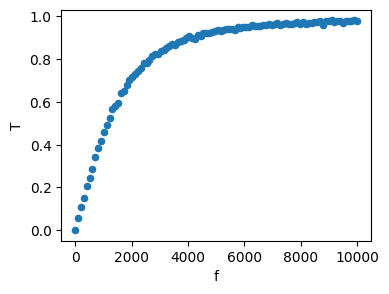

In [45]:
arx = 'datos/RC_PA.csv'
df = pd.read_csv(arx)

print (df.info())

df.plot.scatter(x='f',y='T', figsize=(4,3))

### Modelo

La función de transferencia para este filtro es,
$$
T = \frac{V_{out}}{V_{in}} = \frac{Z_R}{Z_R + Z_C} = \frac{R}{R + \frac{1}{j 2 \pi f C} } = \frac{j 2 \pi f R C}{j 2 \pi f R C + 1 }
$$

$$
T = \frac{j \frac{f}{f_c}}{1+ j \frac{f}{f_c}}, \quad f_c = \frac{1}{2 \pi R C }
$$

El módulo de la función de transferencia es el modelo que tenemos que ajustar,

$$
|T| = \frac{ \frac{f}{f_c} }{ \sqrt{1+(\frac{f}{f_c})^2} }
$$

In [46]:
def modelo_T( f, fc ):
    x = 1.0*f/fc
    T = x/np.sqrt( 1.0 + x**2 )
    return T

# valores medidos
U = 1e4
f = df["f"].to_numpy()/U
T = df["T"].to_numpy()

# frec corte teórica
R= 80e3 
C= 1e-9
fc_th = ( 1.0/(2*np.pi*R*C) )/U 
print( f"Frec corte teórica: {fc_th:.6f} [UHz]")


# Semilla frec corte
fc_ini = 0.1

popt, pcov = curve_fit(modelo_T, f, T, p0=fc_ini )      

fc_exp = popt[0]

# Errores estandar
SE_fc = np.sqrt(np.diag(pcov))[0]

print ("\nParámetros obtenidos del ajuste:")
print(f"fc = ({fc_exp:.6f} ± {SE_fc:.6f}) [UHz]")

Frec corte teórica: 0.198944 [UHz]

Parámetros obtenidos del ajuste:
fc = (0.198347 ± 0.000459) [UHz]


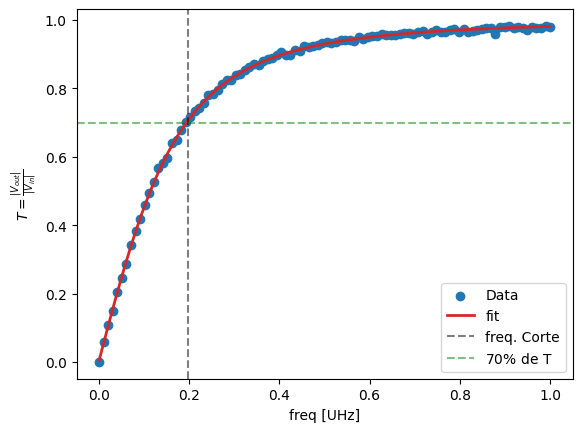

In [47]:
fig,ax = plt.subplots()

ax.scatter( f,T, label='Data' )

ax.plot(f, modelo_T(f,fc_exp), c= 'C3', label='fit', linewidth=2)

ax.axvline( fc_exp, linestyle='--', c='black', alpha=0.5, label='freq. Corte' )

ax.axhline( 0.7, linestyle='--', c='green', alpha=0.5, label=r'$70\%$ de T' )

ax.set_xlabel("freq [UHz]")
ax.set_ylabel(r"$T = \frac{|V_{out}|}{|V_{in}|}$")
ax.legend()
plt.show()

---

# Pasa Altos con circuito RL

Describo en el siguiente apartado un caso patológico de filtro PASA ALTOS con circuito RL: **cuando la resistencia  utilizada es del orden de la resistencia interna del inductor**:

```
 _____ -V0 (SIN)+ _______ R ________ L _ rL ____   
|                     |           |             |  
GND                  Vin         Vout          GND
```

Parámetros:
- R = 125 $\Omega$
- L = 10 $mH$ (Res. int. inductancia $r_L \approx 100 \Omega$)

- Frecuencia de corte $f_c \approx 2$ kHz
- $V_0$ sinusoidal, amplitud $5V$. Barrido en frecuencia  $f \in (10, 10000)$ Hz 
- En $V_{in}$ se mide la amplitud de la señal de entrada (CRMS) respecto de GND (masa) (Res. int. gen. $r_G=50 \Omega$).
- En $V_{out}$ se mide la amplitud de la señal de salida (CRMS) en el capacitor respecto de GND (masa).


Veremos que en este caso, la resistencia interna $r_L$ afectará a la función de transferencia.

Empezamos cargando los datos del experimento,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f       100 non-null    float64
 1   T       100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB
None


<Axes: xlabel='f', ylabel='T'>

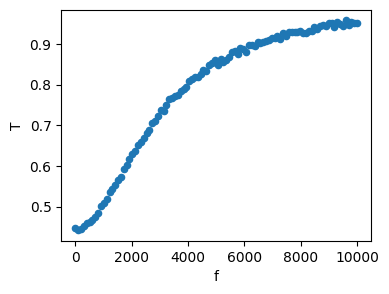

In [48]:
arx = 'datos/RL_PA.csv'
df = pd.read_csv(arx)

print (df.info())

df.plot.scatter(x='f',y='T', figsize=(4,3))

### Modelo

En este ejemplo, la resistencia interna del inductor es del orden de la resistencia $R$. Por lo tanto, tenemos que tenerla en cuenta en nuestra propuesta de modelo. La tensión $V_{out}$ podemos expresarla como una fracción de $V_{in}$ de la siguiente manera,
$$
V_{out} = V_{in} \frac{Z_{r_L} + Z_L}{ Z_{r_L} + Z_L + Z_R }
$$

luego, la función de transferencia es,
$$
T = \frac{V_{out}}{V_{in}} =  \frac{r_L + j 2\pi f L}{ R+r_L + j 2\pi f L } = 
\frac{ A + j B }{C + j B } 
$$

**Frecuencia de corte**

Desarrollando el numero complejo, 

$$
T = \frac{ (A + j B)(C - j B) }{C^2 + B^2 }  = \frac{ AC + B^2 }{ C^2 + B^2 } + j \frac{B(C-A) }{C^2 + B^2}
$$

La frecuencia de corte se define como la frecuencia a la cual la reactancia es igual a la resistencia, en otras palabras cuando la parte real de la función de transferencia es igual a la parte imaginaria,
$$
AC + B^2 = B(C-A)
$$

resolviendo la cuadratica en B,
$$
B = \frac{C-A}{2} \pm \sqrt{ (\frac{C-A}{2})^2 - AC}
$$

reemplazando por los valores de A, B y C, podemos despejar $f_c$,
$$
2\pi f_c L = \frac{R}{2} \pm \sqrt{ (\frac{R}{2})^2 - r_L(r_L+R)}
$$

$$
f_c = \frac{R}{2\pi L} \big[ \frac{1}{2} \pm \sqrt{ (\frac{1}{2})^2 - \frac{r_L(r_L+R)}{R^2}} \big]
$$


Definimos para mayor comodidad $f_0=\frac{R}{2\pi L}$ y $\epsilon = \frac{r_L}{R}$. Luego podemos escribir la frecuencia de corte y la función de transferencia como,

$$
f_c = f_0 \big[ \frac{1}{2} \pm \sqrt{ (\frac{1}{2})^2 - \epsilon(\epsilon+1)} \big]
$$

$$
T = \frac{ \epsilon + j \frac{f}{f_0 } }{ 1+ \epsilon + j \frac{f}{f_0 } }
$$

Noten que si $R \gg r_L$ entonces  $\epsilon \to 0$ y $f_c \to \frac{R}{2\pi L}$. Usualmente la idea es trabajar con componentes electronicos de valores que cumplan esa condición, lamentablemente este no es nuestro caso, por lo cual proponemos trabajar con esa función de transferencia. El modelo para ajustar nuestros datos es el modulo de $T$,

$$
|T| =  \frac{ \sqrt{\epsilon^2 + (\frac{f}{f_0})^2 } }{ \sqrt{(1 + \epsilon)^2 + (\frac{f}{f_0})^2 } }
$$


In [49]:
def modelo_T(f, f0, e):
    x = f/f0
    T= np.sqrt(e**2 + x**2)/ np.sqrt( (1+e)**2 + x**2)

    return T


# variables
U=1e4
f1 = df["f"].to_numpy()/U
T1 = df["T"].to_numpy()

# valores teoricos
R=125
rL=100
L=10e-3

f0_th =  (R/(2*np.pi*L))/U
e_th = rL/R


# Semillas
f0_ini = 0.1
e_ini = 0.1
p0 = [f0_ini, e_ini] 

# Ajuste
popt, pcov = curve_fit(modelo_T, f1, T1, p0=p0)      

f0_exp, e_exp = popt

# Errores estandar
SE_f0, SE_e = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"f0 = ({f0_exp:.6f} ± {SE_f0:.6f}) [UHz]")
print(f"e = ({e_exp:.6f} ± {SE_e:.6f}) [Ohm]")

print ("\nParámetros teóricos:")
print(f"f0 = {f0_th:.6f}  [UHz]")
print(f"e = {e_th:.6f} [Ohm]")


# calculo freq corte teorica

fc = ( f0_exp*( 1/2 + np.sqrt( 1/4 - e_exp*(e_exp-1) ) )    )

print ("\nFreq de corte :")
print(f"fc = {fc:.6f}  [UHz]")



Parámetros obtenidos del ajuste:
f0 = (0.198686 ± 0.000463) [UHz]
e = (0.800939 ± 0.004031) [Ohm]

Parámetros teóricos:
f0 = 0.198944  [UHz]
e = 0.800000 [Ohm]

Freq de corte :
fc = 0.226476  [UHz]


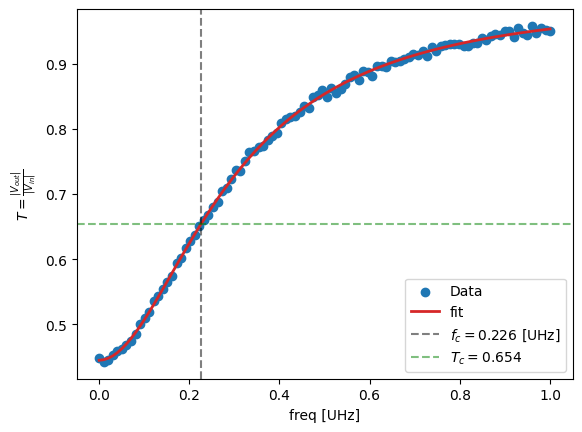

In [50]:
fig,ax = plt.subplots()

ax.scatter( f1,T1, label='Data' )

ax.plot(f1, modelo_T(f1,*popt), c= 'C3', label='fit', linewidth=2)

ax.axvline( fc, linestyle='--', c='black', alpha=0.5, label=f'$f_c = {fc:.3f}$ [UHz]' )


# calculo el valor de la transferencia a la frecuencia de corte
Tc = modelo_T(fc, *popt) 
ax.axhline( Tc, linestyle='--', c='green', alpha=0.5, label=f'$T_c = {Tc:.3f}$' )


ax.set_xlabel("freq [UHz]")
ax.set_ylabel(r"$T = \frac{|V_{out}|}{|V_{in}|}$")
ax.legend()
plt.show()